In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt 
from collections import Counter
from scipy import stats
import gseapy as gp
from community import community_louvain
import seaborn as sns

In [11]:
#Here, we find the resolution parameter that optimizes Newman's modularity
def optimal_resolution_with_diagnostics_simple_network(G, resolution_list,weight,rd_state):
    max_modularity = -1
    modularity_scores = []
    for resolution in resolution_list:
        partition = community_louvain.best_partition(G, resolution=resolution,weight=weight,random_state=rd_state)
        modularity = community_louvain.modularity(partition,G)
        if modularity > max_modularity:   # save the partition and resolution giving the maximum modularity
            max_modularity = modularity
            best_partition = partition
            best_resolution = resolution
        modularity_scores.append((resolution, modularity))
    return best_partition, best_resolution, max_modularity, modularity_scores



In [3]:
with open('output/GGN_characteristics_dict.pickle', 'rb') as handle:
    GGN_characteristics_dict = pk.load(handle)   

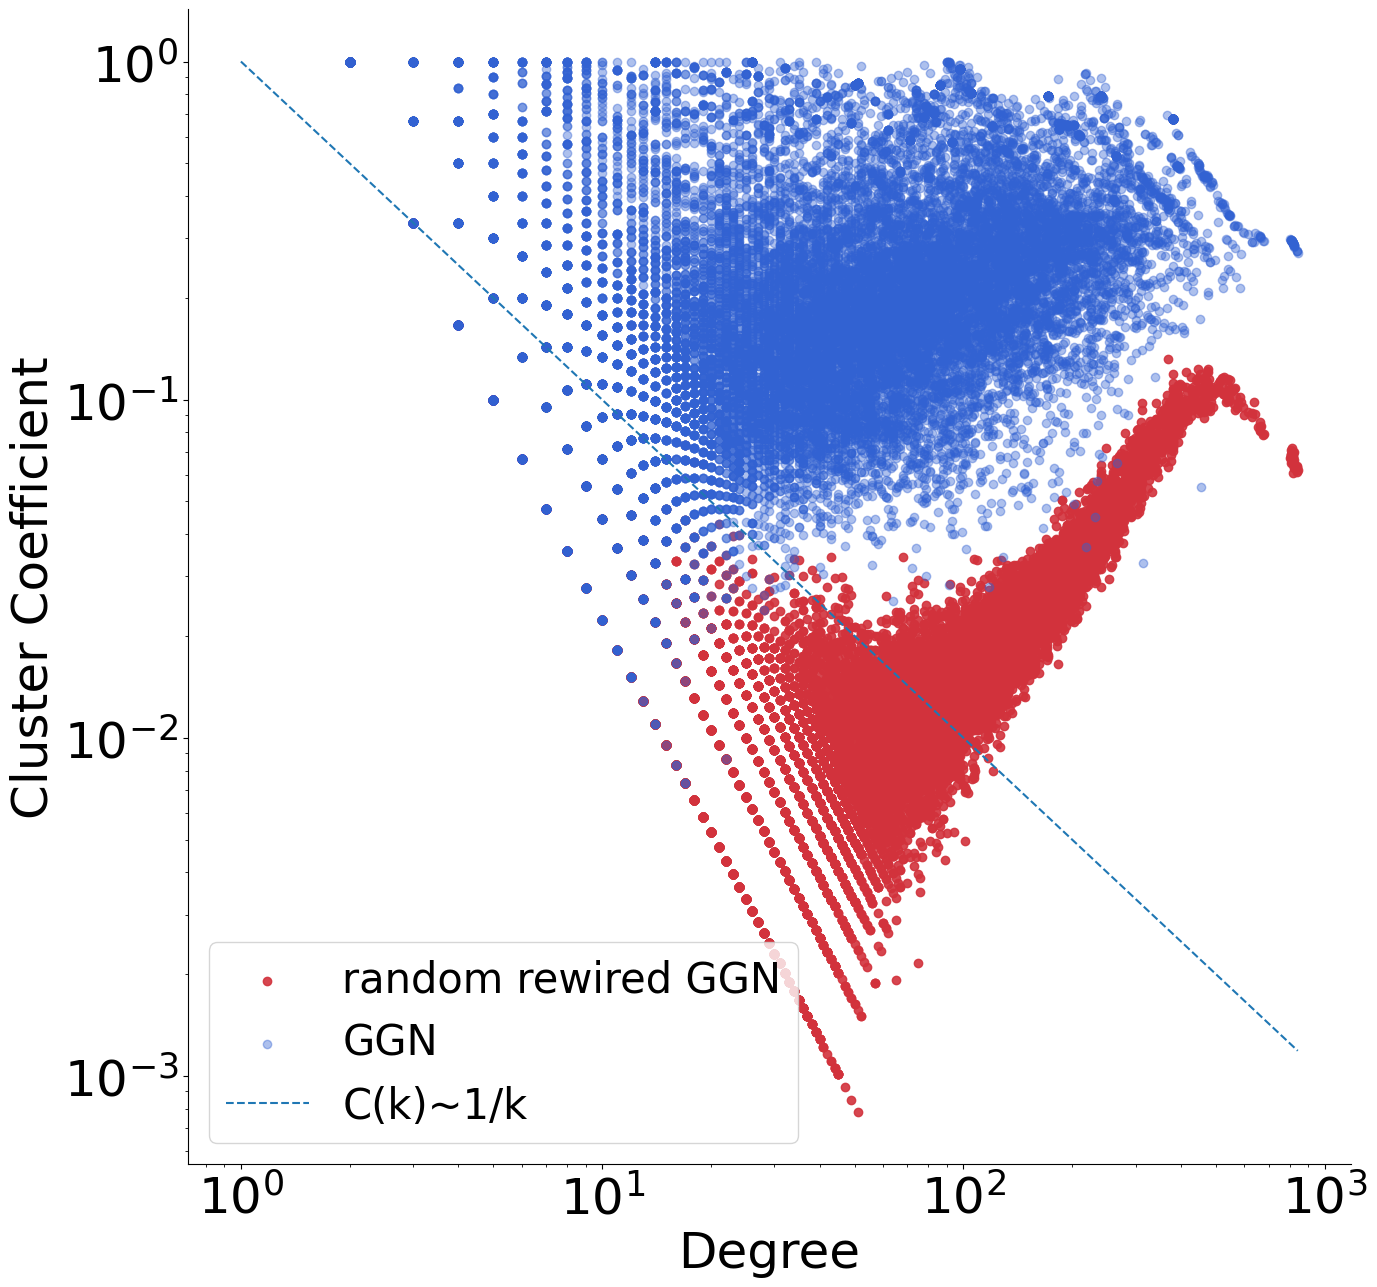

In [4]:
import matplotlib
fig, ax1 = plt.subplots(figsize=(15,15))


plt.scatter(GGN_characteristics_dict["GGN_degree"], GGN_characteristics_dict["random_GGN_clustering_coefficient"], c='#D2323C', alpha=0.9,label="random rewired GGN")
plt.scatter(GGN_characteristics_dict["GGN_degree"], GGN_characteristics_dict["GGN_clustering_coefficient"], c='#3262D2', alpha=0.4,label="GGN")
plt.plot(GGN_characteristics_dict["GGN_degree"], GGN_characteristics_dict["predicted_GGN_clustering_coefficient"], linestyle='dashed',label='C(k)~1/k')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree', fontsize=36)
plt.ylabel('Cluster Coefficient', fontsize=36)
#ax1.set_xticks([1,10, 100, 1000,20000])
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)

#plt.xlim(0,5000)
#plt.title('Exposures assocciated with genes')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.legend(fontsize=30)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 
plt.savefig('output/Figures/AddFig_HierarchicalCom_GGN.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()
plt.close()

In [3]:
#Let's import the randomized EEN
random_ggn_df = pd.read_csv("output/random_ggn.tsv", sep="\t",index_col=0)
random_ggn = nx.from_pandas_edgelist(random_ggn_df, 'Gene A', 'Gene B')

ggn = nx.read_weighted_edgelist("output/backbone_gene_graph_significant_weighted.edgelist")

In [7]:
def optimal_resolution(G, resolution_list,weight,random_state):
    """
    Param:
    G: A networkx graph
    resolution_list: List of resolution values to check
    """
    res_mod_dict = {}
    max_modularity = -1 # initialize maximum modularity as negative value
    for resolution in resolution_list:
        partition = community_louvain.best_partition(G, resolution=resolution,weight=weight,random_state=random_state)
        modularity = community_louvain.modularity(partition,G)
        res_mod_dict[resolution] = modularity

        if modularity > max_modularity:   # save the partition and resolution giving the maximum modularity
            max_modularity = modularity
            best_partition = partition
            best_resolution = resolution
            
    return best_partition, best_resolution, max_modularity,res_mod_dict

In [8]:
def overlap_jaccard(list1,list2):
    intersction_term= len(set(list1) & set(list2))
    denominator = len(set(list1).union(set(list2)))
    overlap_jaccard_coeff = intersction_term/denominator
    return overlap_jaccard_coeff

In [4]:

#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

#Let's import the network
backbone_ss_exposure_network = nx.read_weighted_edgelist("output/backbone_exp_graph_significant_weighted.edgelist")

#This cells create a dictionary where each key is a chemical compound and the correspondent value is a genelist
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])

#Here, we keep only the exposures which perturb at least one gene
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)
    else:
        pass


In [5]:
#Let's try to associate some exposures or some chemical class to these communities
gene_chem = {}
for i,v in chem_homo.iterrows():
    try:
        gene_chem[v["GeneSymbol"]] |= {v["ChemicalID"]}
    except KeyError as e:
        gene_chem[v["GeneSymbol"]] = set([v["ChemicalID"]])
        
gene_chem_cleaned={}
for k,v in gene_chem.items():
    if len(v)!=0:
        gene_chem_cleaned[k]=v
    else:
        pass
#Here, we define the fisher test that we will use
def overlap_set_genes(setA, setB,background):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M= len(background) #total number of exposures in chem_gene_cleaned
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))


from statsmodels.sandbox.stats.multicomp import multipletests
def fdr_adjustment(list_of_pvals,alpha):    
    return multipletests(list_of_pvals,alpha=alpha,method='fdr_bh')[1] #the benjamin hochberg method is used


In [9]:


random_ggn_weighted = nx.Graph()
for e in random_ggn.edges():
    ji= overlap_jaccard(gene_chem_cleaned[e[0]],gene_chem_cleaned[e[1]])  
    random_ggn_weighted.add_edge(*e)
    random_ggn_weighted[e[0]][e[1]]['weight']=ji
    

In [12]:
resolution_list = np.linspace(0.1, 2, 20) 


ggn_best_partition, ggn_best_resolution, ggn_max_modularity, ggn_modularity_scores = optimal_resolution_with_diagnostics_simple_network(ggn, resolution_list,'weight',5495)
random_ggn_best_partition, random_ggn_best_resolution, random_ggn_max_modularity, random_ggn_modularity_scores = optimal_resolution_with_diagnostics_simple_network(random_ggn_weighted, resolution_list,'weight',5495)


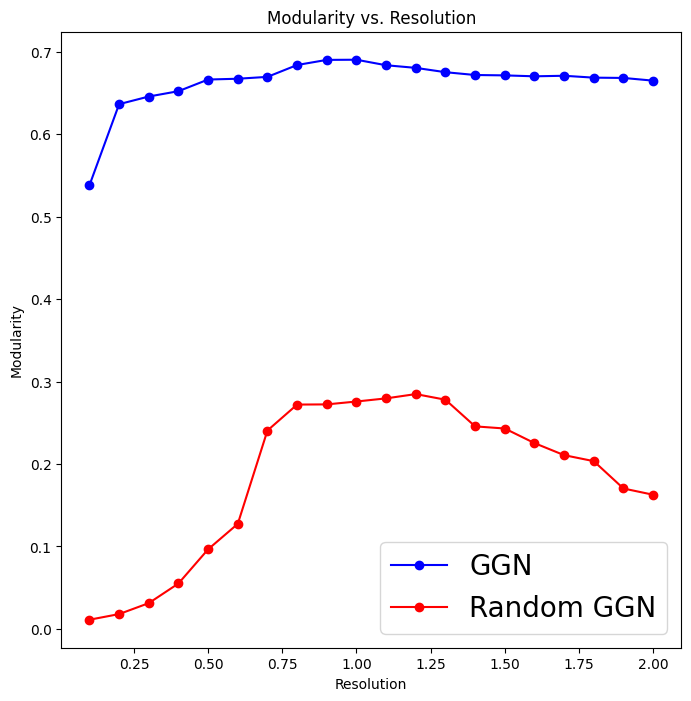

In [13]:
#This plot shows the relationship between resolution and modularity
plt.figure(figsize=(8, 8))
# Plot the modularity versus resolution

plt.plot(resolution_list, [i[1] for i in ggn_modularity_scores], marker='o',color="blue",label='GGN')
plt.plot(resolution_list, [i[1] for i in random_ggn_modularity_scores], marker='o',color="red",label='Random GGN')

plt.xlabel('Resolution')
plt.ylabel('Modularity')
plt.title('Modularity vs. Resolution')
plt.legend(fontsize=20)
plt.savefig('output/Figures/SF20B_v02_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()



In [12]:
resolution_list = np.linspace(0.1, 2, 20) 

best_partition, best_resolution, max_modularity, res_mod_dict = optimal_resolution(random_ggn_weighted, resolution_list,'weight',5495)
print('Optimal resolution value: ', best_resolution)

Optimal resolution value:  1.2


In [13]:
#Here, we calculate the communities in hierarchical fashion with Louvain
#We take into account the weights of the weighted network and the best resolution parameter

dendo = community_louvain.generate_dendrogram(random_ggn_weighted,resolution=1.2 ,weight='weight',random_state=5495)

In [14]:
#There are three hierarchical levels
len(dendo)

3

In [22]:
#Let's define the three hierarchical communities as dictionaries
ee_first_louvain_iteration_exposures={}   

for com in set(list(dendo[0].values())):
    exp_list=[]
    for exp, comcom in dendo[0].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration_exposures[com]=exp_list
    
ee_first_louvain_iteration={}  #this dictionary contains the middle-hierarchical level as keys and the respective (dividing)
                               #finest (first) hierarchical communities as values
for com in set(list(dendo[1].values())):
    exp_list=[]
    for exp, comcom in dendo[1].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration[com]=exp_list
    
ee_second_louvain_iteration={} #this dictionary has the broad-hierarchical (third) level as keys and the respective (dividing)
                               #middle (second) hierarchical communities as values
for com in set(list(dendo[2].values())):
    exp_list=[]
    for exp, comcom in dendo[2].items():
        if com==comcom:
            exp_list.append(exp)
    ee_second_louvain_iteration[com]=exp_list
    
#These communities are the middle and the broad level related to each community

ee_second_louvain_iteration_exposures={}  
for com, com_list in ee_first_louvain_iteration.items():
    exp_list=[]
    for comcom in com_list:
        exp_list.extend(ee_first_louvain_iteration_exposures[comcom])
    ee_second_louvain_iteration_exposures[com]=exp_list

ee_third_louvain_iteration_exposures={}
for com, com_list in ee_second_louvain_iteration.items():
    exp_list=[]
    for comcom in com_list:
        exp_list.extend(ee_second_louvain_iteration_exposures[comcom])
    ee_third_louvain_iteration_exposures[com]=exp_list

In [37]:
#Let's change the nomenclature of these communities

#BROADEST==third
third_level_louvain_sort=dict(sorted(ee_third_louvain_iteration_exposures.items(), key=lambda item: len(item[1]), reverse = True))
third_renamed_third_conversion_dict={}
renamed_third_level_louvain_sort={}
c=1
for com,explist in third_level_louvain_sort.items():
    renamed_third_level_louvain_sort[str(c)]=explist
    third_renamed_third_conversion_dict[com]=str(c)
    c=c+1
    
#MIDDLE==second

second_renamed_second_conversion_dict={}
renamed_second_level_louvain_sort={}

for br_com,mid_com in ee_second_louvain_iteration.items():
    if len(mid_com)==1:
        newcom=third_renamed_third_conversion_dict[br_com]
        renamed_second_level_louvain_sort[newcom]=ee_second_louvain_iteration_exposures[mid_com[0]]
        second_renamed_second_conversion_dict[mid_com[0]]=newcom
    else:
        sorted_list=list(sorted(mid_com, key=lambda item: len(ee_second_louvain_iteration_exposures[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=third_renamed_third_conversion_dict[br_com]+"_"+str(q)
            renamed_second_level_louvain_sort[newcom]=ee_second_louvain_iteration_exposures[sorted_list[i]]
            second_renamed_second_conversion_dict[sorted_list[i]]=newcom
        
#FINEST==first  

first_renamed_first_conversion_dict={}
renamed_first_level_louvain_sort={}

for mid_com,fin_com in ee_first_louvain_iteration.items():
    if len(fin_com)==1:
        newcom=second_renamed_second_conversion_dict[mid_com]
        renamed_first_level_louvain_sort[newcom]=ee_first_louvain_iteration_exposures[fin_com[0]]
        first_renamed_first_conversion_dict[fin_com[0]]=newcom
    else:
        sorted_list=list(sorted(fin_com, key=lambda item: len(ee_first_louvain_iteration_exposures[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=second_renamed_second_conversion_dict[mid_com]+"_"+str(q)
            renamed_first_level_louvain_sort[newcom]=ee_first_louvain_iteration_exposures[sorted_list[i]]
            first_renamed_first_conversion_dict[sorted_list[i]]=newcom
        
third_renamed_third_conversion_dict_rev={}
for k,v in third_renamed_third_conversion_dict.items():
    third_renamed_third_conversion_dict_rev[v]=k

second_renamed_second_conversion_dict_rev={}
for k,v in second_renamed_second_conversion_dict.items():
    second_renamed_second_conversion_dict_rev[v]=k

first_renamed_first_conversion_dict_rev={}
for k,v in first_renamed_first_conversion_dict.items():
    first_renamed_first_conversion_dict_rev[v]=k
    

In [23]:
#Let's change the nomenclature of these communities

#BROADEST==third
third_level_louvain_sort=dict(sorted(ee_third_louvain_iteration_exposures.items(), key=lambda item: len(item[1]), reverse = True))
third_renamed_third_conversion_dict={}
renamed_third_level_louvain_sort={}
c=1
for com,explist in third_level_louvain_sort.items():
    renamed_third_level_louvain_sort[str(c)]=explist
    third_renamed_third_conversion_dict[com]=str(c)
    c=c+1
    
#MIDDLE==second

second_renamed_second_conversion_dict={}
renamed_second_level_louvain_sort={}

for br_com,mid_com in ee_second_louvain_iteration.items():
    if len(mid_com)==1:
        newcom=third_renamed_third_conversion_dict[br_com]
        renamed_second_level_louvain_sort[newcom]=ee_second_louvain_iteration_exposures[mid_com[0]]
        second_renamed_second_conversion_dict[mid_com[0]]=newcom
    else:
        sorted_list=list(sorted(mid_com, key=lambda item: len(ee_second_louvain_iteration_exposures[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=third_renamed_third_conversion_dict[br_com]+"_"+str(q)
            renamed_second_level_louvain_sort[newcom]=ee_second_louvain_iteration_exposures[sorted_list[i]]
            second_renamed_second_conversion_dict[sorted_list[i]]=newcom
        
#FINEST==first  

first_renamed_first_conversion_dict={}
renamed_first_level_louvain_sort={}

for mid_com,fin_com in ee_first_louvain_iteration.items():
    if len(fin_com)==1:
        newcom=second_renamed_second_conversion_dict[mid_com]
        renamed_first_level_louvain_sort[newcom]=ee_first_louvain_iteration_exposures[fin_com[0]]
        first_renamed_first_conversion_dict[fin_com[0]]=newcom
    else:
        sorted_list=list(sorted(fin_com, key=lambda item: len(ee_first_louvain_iteration_exposures[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=second_renamed_second_conversion_dict[mid_com]+"_"+str(q)
            renamed_first_level_louvain_sort[newcom]=ee_first_louvain_iteration_exposures[sorted_list[i]]
            first_renamed_first_conversion_dict[sorted_list[i]]=newcom
        
third_renamed_third_conversion_dict_rev={}
for k,v in third_renamed_third_conversion_dict.items():
    third_renamed_third_conversion_dict_rev[v]=k

second_renamed_second_conversion_dict_rev={}
for k,v in second_renamed_second_conversion_dict.items():
    second_renamed_second_conversion_dict_rev[v]=k

first_renamed_first_conversion_dict_rev={}
for k,v in first_renamed_first_conversion_dict.items():
    first_renamed_first_conversion_dict_rev[v]=k
    

In [44]:
#We are using the new nomenclature
fine_grained_communities_list=[]
middle_communities_list=[]
broad_communities_list=[]

for com,explist in renamed_first_level_louvain_sort.items():
    comlist=com.split("_")
    if len(comlist)==1:
        fine_grained_communities_list.append(com)
    elif len(comlist)==2:
        if comlist[0] not in set([c[0] for c in renamed_first_level_louvain_sort.keys() if len(c.split("_"))>2]):
            fine_grained_communities_list.append(com)
            middle_communities_list.append(comlist[0])
    else:
        fine_grained_communities_list.append(com)
        middle_communities_list.append(comlist[0]+"_"+comlist[1])
        broad_communities_list.append(comlist[0])

fine_grained_communities_set=set(fine_grained_communities_list)
middle_communities_set=set(middle_communities_list)
broad_communities_set=set(broad_communities_list)
print(len(broad_communities_set))  
print(len(middle_communities_set))  
print(len(fine_grained_communities_set))  

2
13
619


In [61]:
random_fine_grained_communities_dict={}
random_middle_communities_dict={}
random_broad_communities_dict={}

for com in fine_grained_communities_set:
    random_fine_grained_communities_dict[com]=renamed_first_level_louvain_sort[com]
    
for com in middle_communities_set:
    random_middle_communities_dict[com]=renamed_second_level_louvain_sort[com]

for com in broad_communities_set:
    random_broad_communities_dict[com]=renamed_third_level_louvain_sort[com]
    
with open('output/Communities/Louvain/random_ggn_fine_grained_communities_dict.pickle', 'wb') as handle:
    pk.dump(random_fine_grained_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/random_ggn_middle_communities_dict.pickle', 'wb') as handle:
    pk.dump(random_middle_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/random_ggn_broad_communities_dict.pickle', 'wb') as handle:
    pk.dump(random_broad_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [48]:
#Here, we define the fisher test that we will use
def overlap_set_genes(setA, setB,background):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M= len(background) #total number of exposures in chem_gene_cleaned
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))


from statsmodels.sandbox.stats.multicomp import multipletests
def fdr_adjustment(list_of_pvals,alpha):    
    return multipletests(list_of_pvals,alpha=alpha,method='fdr_bh')[1] #the benjamin hochberg method is used


In [51]:
significant_random_gg_Louvain_fine_grained_dict ={}
for com,gene_set in fine_grained_communities_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_random_gg_Louvain_fine_grained_dict[com]= significant_chem_class
    
significant_random_gg_Louvain_middle_dict = {}
for com,gene_set in middle_communities_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_random_gg_Louvain_middle_dict[com]= significant_chem_class
    
significant_random_gg_Louvain_broad_dict = {}
for com,gene_set in broad_communities_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_random_gg_Louvain_broad_dict[com]= significant_chem_class
    

In [53]:
with open('output/Communities/Louvain/significant_random_gg_Louvain_fine_grained_dict.pickle', 'wb') as handle:
    pk.dump(significant_random_gg_Louvain_fine_grained_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/significant_random_gg_Louvain_middle_dict.pickle', 'wb') as handle:
    pk.dump(significant_random_gg_Louvain_middle_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/significant_random_gg_Louvain_broad_dict.pickle', 'wb') as handle:
    pk.dump(significant_random_gg_Louvain_broad_dict, handle, protocol=pk.HIGHEST_PROTOCOL)



In [54]:
#Let's import the Infomap fine-grained community

with open('output/Communities/Infomap/random_ggn_infomap_fine_grained_communities_dict.pickle', 'rb') as handle:
    random_ggn_infomap_fine_grained_communities_dict = pk.load(handle)


In [56]:


significant_random_gg_Infomap_fine_grained_dict ={}
for com,gene_set in random_ggn_infomap_fine_grained_communities_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_random_gg_Infomap_fine_grained_dict[com]= significant_chem_class
    

In [58]:
#Let's import the real GGN communities
#Louvain
with open('output/Communities/Louvain/gg_Louvain_fine_grained_dict.pickle', 'rb') as handle:
    gg_Louvain_fine_grained_dict = pk.load(handle)
    
with open('output/Communities/Louvain/gg_Louvain_middle_dict.pickle', 'rb') as handle:
    gg_Louvain_middle_dict = pk.load(handle)
    
with open('Communities/Louvain/gg_Louvain_broad_dict.pickle', 'rb') as handle:
    gg_Louvain_broad_dict = pk.load(handle)
    


#Infomap
with open('output/Communities/Infomap/gg_ji_infomap_fine_grained_communities_dict.pickle', 'rb') as handle:
    gg_Infomap_fine_grained_dict = pk.load(handle)

with open('output/Communities/Infomap/gg_ji_infomap_middle_communities_dict.pickle', 'rb') as handle:
    gg_Infomap_middle_dict = pk.load(handle)

with open('output/Communities/Infomap/gg_ji_infomap_broad_communities_dict.pickle', 'rb') as handle:
    gg_Infomap_broad_dict = pk.load(handle)



C:\Users\salvo\AppData\Local\Temp\ipykernel_19084\3433643421.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size=36)


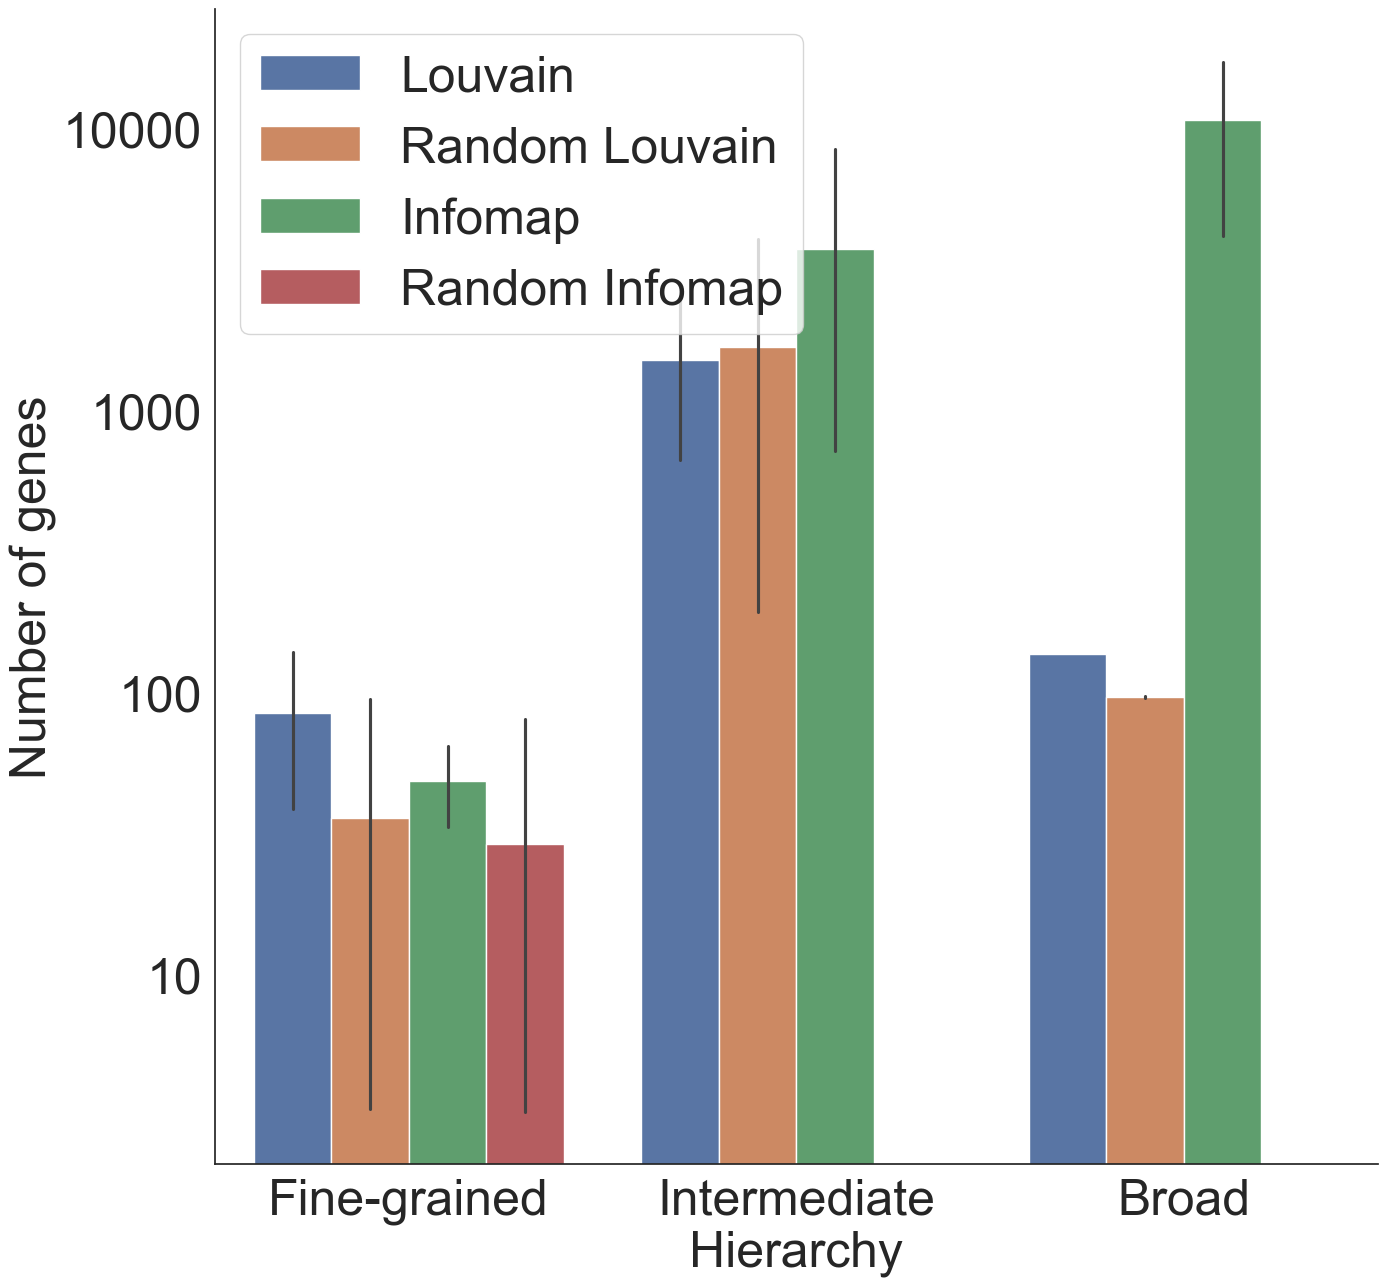

In [65]:

com_size_df=pd.DataFrame()

status_list=[]
num_terms_list=[]
level_list=[]

for com,expset in gg_Louvain_fine_grained_dict.items():
    status_list.append("Fine-grained")
    num_terms_list.append(len(expset))
    level_list.append("Louvain")

for com,expset in random_fine_grained_communities_dict.items():
    status_list.append("Fine-grained")
    num_terms_list.append(len(expset))
    level_list.append("Random Louvain")

for com,expset in gg_Infomap_fine_grained_dict.items():
    status_list.append("Fine-grained")
    num_terms_list.append(len(expset))
    level_list.append("Infomap")

for com,expset in random_ggn_infomap_fine_grained_communities_dict.items():
    status_list.append("Fine-grained")
    num_terms_list.append(len(expset))
    level_list.append("Random Infomap")

for com,expset in gg_Louvain_middle_dict.items():
    status_list.append("Intermediate")
    num_terms_list.append(len(expset))
    level_list.append("Louvain")

for com,expset in random_middle_communities_dict.items():
    status_list.append("Intermediate")
    num_terms_list.append(len(expset))
    level_list.append("Random Louvain")

for com,expset in gg_Infomap_middle_dict.items():
    status_list.append("Intermediate")
    num_terms_list.append(len(expset))
    level_list.append("Infomap")

for com,expset in gg_Louvain_broad_dict.items():
    status_list.append("Broad")
    num_terms_list.append(len(expset))
    level_list.append("Louvain")

for com,expset in random_broad_communities_dict.items():
    status_list.append("Broad")
    num_terms_list.append(len(expset))
    level_list.append("Random Louvain")

for com,expset in gg_Infomap_broad_dict.items():
    status_list.append("Broad")
    num_terms_list.append(len(expset))
    level_list.append("Infomap")

com_size_df['Hierarchy']=status_list
com_size_df['Number of exposures']=num_terms_list
com_size_df['Type']=level_list


# Create a boxplot using seaborn
fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.barplot(x='Hierarchy', y='Number of exposures', hue='Type', data=com_size_df)
g.set_yscale("log")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size=36)
plt.xticks(fontsize=36)

plt.xlabel('Hierarchy', fontsize=36)
plt.ylabel('Number of genes', fontsize=36)
plt.legend(fontsize=36)
plt.savefig('output/Figures/Supplementary_Number_Genes_GGN_Network_Type.pdf', format='pdf', dpi=300, bbox_inches="tight")
plt.show()


In [66]:
significant_gg_Louvain_fine_grained_dict ={}
for com,gene_set in gg_Louvain_fine_grained_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Louvain_fine_grained_dict[com]= significant_chem_class
    
significant_gg_Louvain_middle_dict = {}
for com,gene_set in gg_Louvain_middle_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Louvain_middle_dict[com]= significant_chem_class
    
significant_gg_Louvain_broad_dict = {}
for com,gene_set in gg_Louvain_broad_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Louvain_broad_dict[com]= significant_chem_class
    
    

In [68]:
significant_gg_Infomap_fine_grained_dict ={}
for com,gene_set in gg_Infomap_fine_grained_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Infomap_fine_grained_dict[com]= significant_chem_class
    
significant_gg_Infomap_middle_dict = {}
for com,gene_set in gg_Infomap_middle_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Infomap_middle_dict[com]= significant_chem_class
    
significant_gg_Infomap_broad_dict = {}
for com,gene_set in gg_Infomap_broad_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene_cleaned.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),gene_chem_cleaned))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()),0.05)
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Infomap_broad_dict[com]= significant_chem_class
    
    

In [79]:
from matplotlib.ticker import LogLocator, LogFormatter
com_size_df=pd.DataFrame()

status_list=[]
num_terms_list=[]
level_list=[]

for com,expset in significant_gg_Louvain_fine_grained_dict.items():
    status_list.append("Fine-grained")
    num_terms_list.append(len(expset))
    level_list.append("Louvain")

for com,expset in significant_random_gg_Louvain_fine_grained_dict.items():
    status_list.append("Fine-grained")
    num_terms_list.append(len(expset))
    level_list.append("Random Louvain")

for com,expset in significant_gg_Infomap_fine_grained_dict.items():
    status_list.append("Fine-grained")
    num_terms_list.append(len(expset))
    level_list.append("Infomap")

for com,expset in significant_random_gg_Infomap_fine_grained_dict.items():
    status_list.append("Fine-grained")
    num_terms_list.append(len(expset))
    level_list.append("Random Infomap")

for com,expset in significant_gg_Louvain_middle_dict.items():
    status_list.append("Intermediate")
    num_terms_list.append(len(expset))
    level_list.append("Louvain")

for com,expset in significant_random_gg_Louvain_middle_dict.items():
    status_list.append("Intermediate")
    num_terms_list.append(len(expset))
    level_list.append("Random Louvain")

for com,expset in significant_gg_Infomap_middle_dict.items():
    status_list.append("Intermediate")
    num_terms_list.append(len(expset))
    level_list.append("Infomap")

for com,expset in significant_gg_Louvain_broad_dict.items():
    status_list.append("Broad")
    num_terms_list.append(len(expset))
    level_list.append("Louvain")

for com,expset in significant_random_gg_Louvain_broad_dict.items():
    status_list.append("Broad")
    num_terms_list.append(len(expset))
    level_list.append("Random Louvain")

for com,expset in significant_gg_Infomap_broad_dict.items():
    status_list.append("Broad")
    num_terms_list.append(len(expset))
    level_list.append("Infomap")

com_size_df['Hierarchy']=status_list
com_size_df['Number of exposures']=num_terms_list
com_size_df['Type']=level_list





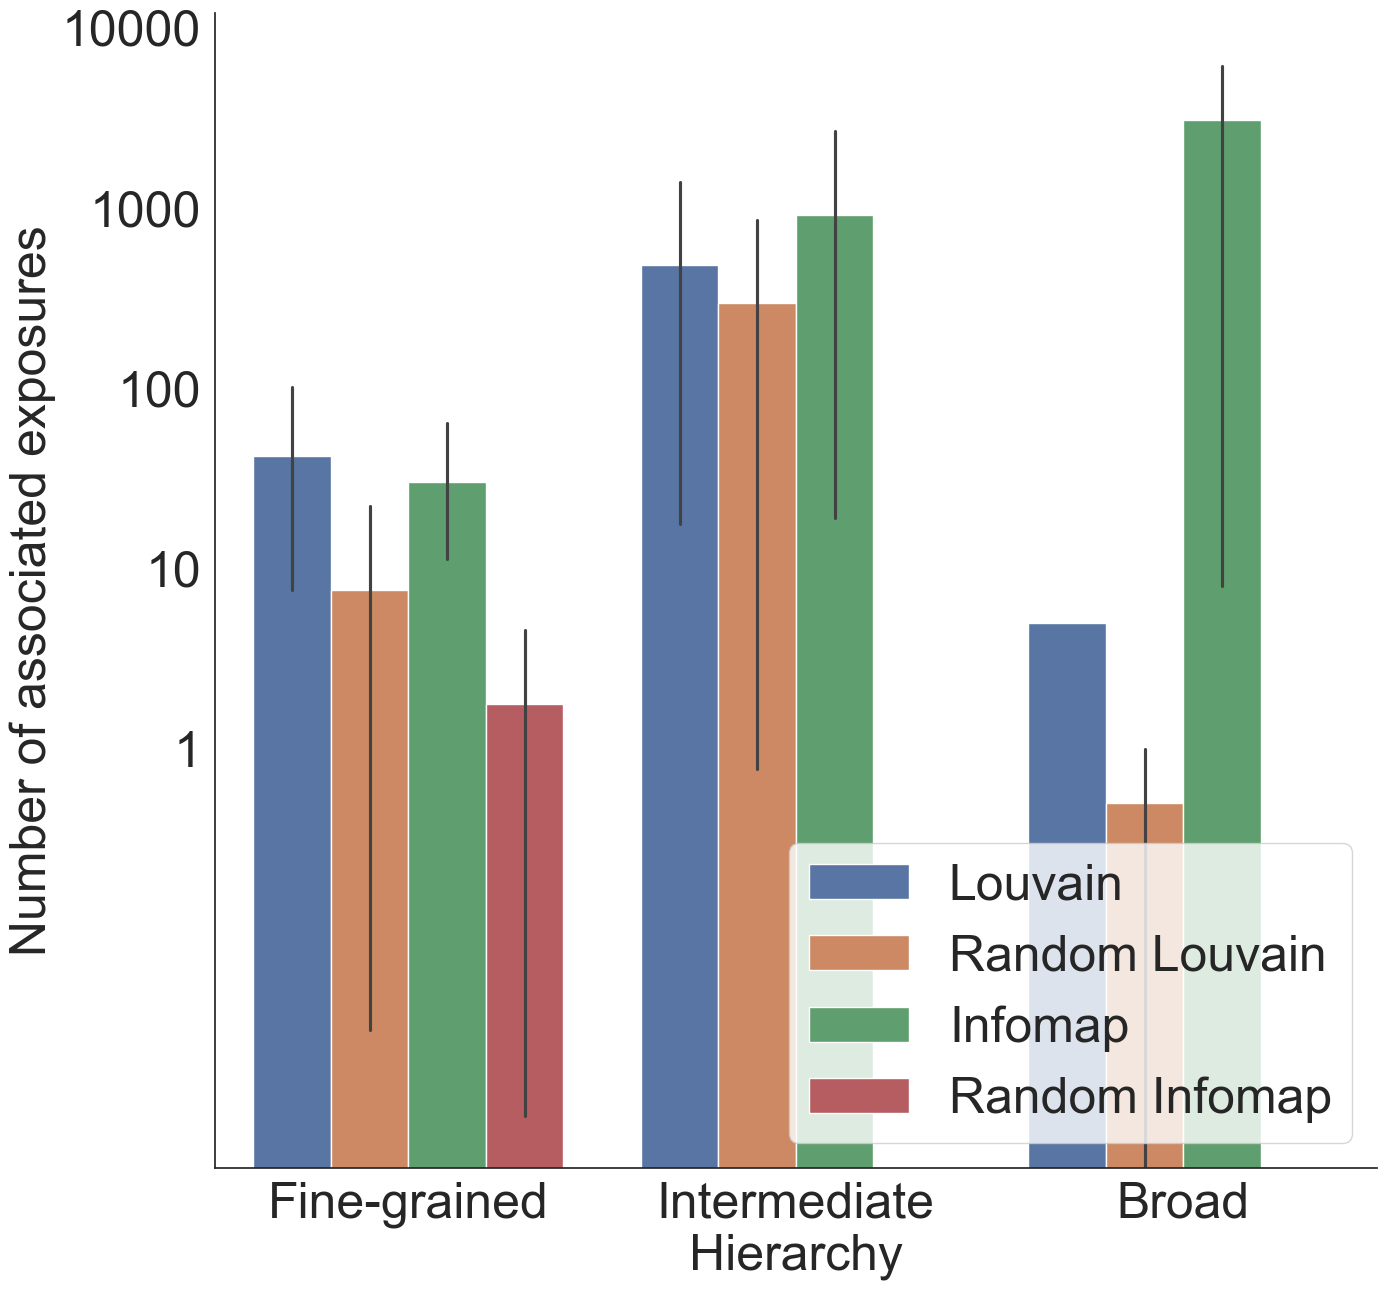

In [80]:

from matplotlib.ticker import LogLocator, LogFormatter

# Your code for creating com_size_df is assumed here

# Create a boxplot using seaborn
fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g = sns.barplot(x='Hierarchy', y='Number of exposures', hue='Type', data=com_size_df)
g.set_yscale("log")

# Remove the top and right spines, and keep bottom and left
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# Set the y-axis ticks manually to handle the log scale better
y_ticks = [1, 10, 100, 1000, 10000]  # Customize as per your data range
ax.set_yticks(y_ticks)

# Set tick labels in log scale format
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())

# Set the fontsize for ticks
ax.tick_params(axis='y', labelsize=36)
plt.xticks(fontsize=36)

# Labels and title
plt.xlabel('Hierarchy', fontsize=36)
plt.ylabel('Number of associated exposures', fontsize=36)
plt.legend(fontsize=36)

# Save the figure
plt.savefig('output/Figures/Supplementary_Number_Exposures_GGN_Network_Type.pdf', format='pdf', dpi=300, bbox_inches="tight")
plt.show()
